In [1]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from time import time
import matplotlib.pyplot as plt

In [24]:
class MnistClassifier(torch.nn.Module):

    def __init__(self):
        super(MnistClassifier, self).__init__()

        self.features = torch.nn.Sequential(                    # inp: B 1 28 28
            torch.nn.Conv2d(1, 32, 3, stride=1, padding=0),     # B 32 26 26
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=1, padding=0),    # B 32 24 24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 32 12 12
            torch.nn.Conv2d(32, 64, 3, stride=1, padding=0),    # B 64 10 10
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 3, stride=1, padding=0),    # B 64 8 8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, stride=2, padding=0),         # B 64 4 4
            torch.nn.Conv2d(64, 128, 3, stride=1, padding=0),   # B 128 2 2
            torch.nn.ReLU(),
        )

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4 * 128, 128),                      # B 128
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)                            # B 10
        )

        self.log_prob_cal = torch.nn.LogSoftmax(dim=-1)
        self.optimizer = torch.optim.Adam(filter(
            lambda p: p.requires_grad, self.parameters()), 
            lr=0.001
        )

        self.batch_x_placeholder = torch.zeros(size=[1, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))
        self.batch_y_placeholder = torch.zeros(size=[1], dtype=torch.long, device=torch.device('cuda:0'))
    
    def forward(self, b_x, b_y=None):
        conv_features = self.features(b_x)
        class_scores = self.decider(conv_features.flatten(1))
        log_probs = self.log_prob_cal(class_scores)
        loss = -1 * torch.mean(log_probs[torch.arange(b_x.shape[0]), b_y])
        decision = torch.argmax(log_probs, dim=-1)
        return decision, loss
    
    def train_epoch(self, X_train, y_train, batch_size):
        self.train()

        iters_per_epoch = int(np.ceil(1.0 * len(X_train) / batch_size))

        # shuffling
        indices = np.arange(len(X_train))

        epoch_loss = 0
        tps = 0

        # iterate over training set
        for iter in range(iters_per_epoch):
            batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

            # reshape placeholder
            if len(batch_indices) != len(self.batch_x_placeholder):
                self.batch_x_placeholder.resize_([len(batch_indices), 1, 28, 28])
                self.batch_y_placeholder.resize_([len(batch_indices)])

            self.batch_x_placeholder.copy_(torch.Tensor(X_train[batch_indices, :, :, :]))
            self.batch_y_placeholder.copy_(torch.Tensor(y_train[batch_indices].astype(int)))

            b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)
            b_decision = b_decision.cpu().numpy()

            epoch_loss += float(b_loss) / iters_per_epoch
            tps += np.sum(y_train[batch_indices].astype(int) == b_decision)

            b_loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            
        epoch_train_accuracy = tps * 100.0 / len(X_train)

        return epoch_loss, epoch_train_accuracy
    
    def evaluate(self, X, y, batch_size):
        with torch.no_grad():
            self.eval()

            iters_per_epoch = int(np.ceil(1.0 * len(X) / batch_size))

            indices = np.arange(len(X))
            np.random.shuffle(indices)

            loss = 0
            tps = 0

            for iter in range(iters_per_epoch):
                batch_indices = indices[iter * batch_size: min(len(indices), (iter + 1) * batch_size)]

                # reshape placeholder
                if len(batch_indices) != len(self.batch_x_placeholder):
                    self.batch_x_placeholder.resize_([len(batch_indices), 1, 28, 28])
                    self.batch_y_placeholder.resize_([len(batch_indices)])
                    
                self.batch_x_placeholder.copy_(torch.Tensor(X[batch_indices]))
                self.batch_y_placeholder.copy_(torch.Tensor(y[batch_indices].astype(int)))

                b_decision, b_loss = self(self.batch_x_placeholder, self.batch_y_placeholder)
                b_decision = b_decision.cpu().numpy()

                loss += float(b_loss) / iters_per_epoch
                tps += np.sum(y[batch_indices].astype(int) == b_decision)

            accuracy = tps * 100.0 / len(X)

            return loss, accuracy

    def fit(self, X_train, y_train, epochs, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

        train_loss = np.zeros((epochs,))
        val_loss = np.zeros((epochs,))
        train_acc = np.zeros((epochs,))
        val_acc = np.zeros((epochs,))

        val_iters_per_epoch = int(np.ceil(1.0 * len(X_val) / batch_size))

        for e in range(epochs):
            t_start = time()

            # train over dataset
            epoch_train_loss, epoch_train_accuracy = self.train_epoch(X_train, y_train, batch_size)
            train_loss[e] = epoch_train_loss
            train_acc[e] = epoch_train_accuracy

            # validating over validation set
            epoch_val_loss, epoch_val_accuracy = self.evaluate(X_val, y_val, batch_size)
            val_loss[e] = epoch_val_loss
            val_acc[e] = epoch_val_accuracy

            #saving model
            torch.save({
                    'epoch': e,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'model_state_dict': self.state_dict(),
                    'epoch_train_loss': epoch_train_loss,
                    'epoch_train_accuracy': epoch_train_accuracy,
                    'epoch_val_loss': epoch_val_loss,
                    'epoch_val_accuracy': epoch_val_accuracy
                }, f'MNIST/epoch_{e}_state.pt')

            print(f'Epoch {e} finished in {time() - t_start:.2f}s. loss: {epoch_train_loss:.4f} - acc: {epoch_train_accuracy:.2f} - val loss: {epoch_val_loss:.4f} - val acc: {epoch_val_accuracy:.2f}')
        
        return train_loss, val_loss, train_acc, val_acc

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
y = mnist.target

In [4]:
X = mnist.data.reshape(70000, 1, 28, 28)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [25]:
model = MnistClassifier()
model.cuda()

MnistClassifier(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
  )
  (decider): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (log_prob_cal): LogSoftmax(dim=-1)
)

In [26]:
batch_size = 64
epochs = 20

In [27]:
train_loss, val_loss, train_acc, val_acc = model.fit(X_train, y_train, epochs, batch_size)

Epoch 0 finished in 3.16s. loss: 0.2061 - acc: 93.44 - val loss: 0.0549 - val acc: 98.40
Epoch 1 finished in 3.08s. loss: 0.0696 - acc: 97.94 - val loss: 0.0476 - val acc: 98.70
Epoch 2 finished in 3.07s. loss: 0.0530 - acc: 98.41 - val loss: 0.0471 - val acc: 98.77
Epoch 3 finished in 3.08s. loss: 0.0430 - acc: 98.73 - val loss: 0.0457 - val acc: 98.76
Epoch 4 finished in 3.06s. loss: 0.0367 - acc: 98.90 - val loss: 0.0374 - val acc: 98.99
Epoch 5 finished in 3.16s. loss: 0.0353 - acc: 98.93 - val loss: 0.0559 - val acc: 98.64
Epoch 6 finished in 3.17s. loss: 0.0306 - acc: 99.08 - val loss: 0.0539 - val acc: 98.84
Epoch 7 finished in 3.15s. loss: 0.0305 - acc: 99.13 - val loss: 0.0539 - val acc: 98.71
Epoch 8 finished in 3.17s. loss: 0.0299 - acc: 99.15 - val loss: 0.0478 - val acc: 98.92
Epoch 9 finished in 3.07s. loss: 0.0228 - acc: 99.32 - val loss: 0.0503 - val acc: 99.04
Epoch 10 finished in 3.10s. loss: 0.0266 - acc: 99.18 - val loss: 0.0442 - val acc: 99.11
Epoch 11 finished in

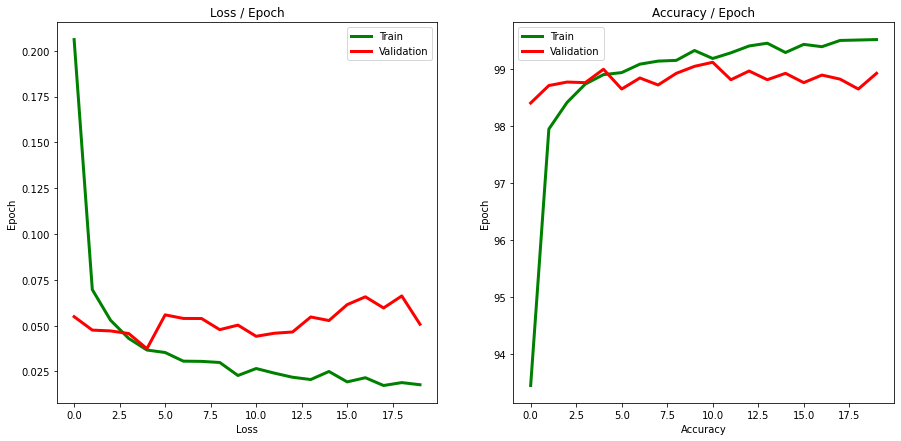

In [28]:
fig = plt.figure(figsize=(15, 7))

# loss
ax = fig.add_subplot(121)
ax.set_title('Loss / Epoch')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='green', linewidth=3)
plt.plot(val_loss, label='Validation', color='red', linewidth=3)


plt.legend()

# acc
ax = fig.add_subplot(122)
ax.set_title('Accuracy / Epoch')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_acc, label='Train', color='green', linewidth=3)
plt.plot(val_acc, label='Validation', color='red', linewidth=3)


plt.legend()

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size)
print(f'Test loss: {test_loss:.4f} - Accuracy: {test_accuracy:.2f}')

Test loss: 0.0428 - Accuracy: 99.03
